In [2]:
import atlite
import geopandas
import logging

logging.basicConfig(level=logging.INFO)

sweden = geopandas.read_file("data/geo/georef-sweden-kommun@public.geojson")

# Filter # Västra götalands län (14)
vgr_code = "14" 
vgr = sweden.loc[sweden.lan_code.apply(lambda x: vgr_code in x)]

# Simplify data with removing array (string[] => string)
vgr['kom_code'] = vgr['kom_code'].apply(lambda x: x[0])
vgr['kom_name'] = vgr['kom_name'].apply(lambda x: x[0])
vgr['lan_code'] = vgr['lan_code'].apply(lambda x: x[0])
vgr['lan_name'] = vgr['lan_name'].apply(lambda x: x[0])

minx = min(vgr.geometry.apply(lambda geom: geom.bounds[0]))
miny = min(vgr.geometry.apply(lambda geom: geom.bounds[1]))
maxx = max(vgr.geometry.apply(lambda geom: geom.bounds[2]))
maxy = max(vgr.geometry.apply(lambda geom: geom.bounds[3]))

print(f"Longitude (min/max) {minx} {maxx}")
print(f"Latitude  (min/max) {miny} {maxy}")

cutout = atlite.Cutout(
    path="vgr-test-kommun-month-01.nc",
    module="era5",
    x=slice(minx, maxx),
    y=slice(miny, maxy),
    time=slice("2011-01","2011-01"),
    dx=0.125,
    dy=0.125,
    dt="3h"
)

cutout.prepare(features=['influx', 'temperature'])

/home/celin/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
INFO:atlite.cutout:Building new cutout vgr-test-kommun-month-01.nc
INFO:atlite.data:Storing temporary files in /tmp/tmpa_c22xjn
INFO:atlite.data:Calculating and writing with module era5:
INFO:atlite.datasets.era5:Requesting data for feature influx...
INFO:atlite.datasets.era5:Requesting data for feature temperature...


Longitude (min/max) 10.592075916575439 14.778931341132603
Latitude  (min/max) 57.14551298876065 59.262765960857905


INFO:atlite.datasets.era5:CDS: Downloading variables
	surface_net_solar_radiation (2011-1)
	surface_solar_radiation_downwards (2011-1)
	toa_incident_solar_radiation (2011-1)
	total_sky_direct_solar_radiation_at_surface (2011-1)

INFO:atlite.datasets.era5:CDS: Downloading variables                            
	2m_temperature (2011-1)
	soil_temperature_level_4 (2011-1)

/home/celin/.local/lib/python3.10/site-packages/atlite/datasets/era5.py:99: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "expver" in ds.dims.keys():


[####################################### ] | 99% Completed | 105.82 ms

/home/celin/.local/lib/python3.10/site-packages/atlite/datasets/era5.py:99: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "expver" in ds.dims.keys():


[########################################] | 100% Completed | 408.57 ms


/home/celin/.local/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<Cutout "vgr-test-kommun-month-01">
 x = 10.62 ⟷ 14.75, dx = 0.12
 y = 57.25 ⟷ 59.25, dy = 0.12
 time = 2011-01-01 ⟷ 2011-01-31, dt = 3h
 module = era5
 prepared_features = ['influx', 'temperature']

In [3]:
import atlite
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

CORINE = "data/geo/corine.tif"
excluder = ExclusionContainer()
excluder.add_raster(CORINE, codes=range(20))

In [4]:
selected_kom_code = "1480" # Gbg

In [5]:
kom = vgr.loc[vgr.kom_code.apply(lambda x: selected_kom_code in x)]

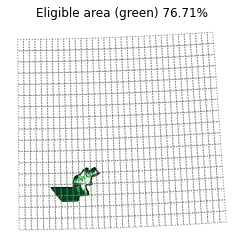

In [6]:
this_kom = kom.geometry.to_crs(excluder.crs)

masked, transform = excluder.compute_shape_availability(this_kom)

eligible_share = masked.sum() * excluder.res**2 / this_kom.geometry.item().area

fig, ax = plt.subplots()
excluder.plot_shape_availability(this_kom, ax=ax)
cutout.grid.to_crs(excluder.crs).plot(edgecolor="grey", color="None", ax=ax, ls=":")
ax.set_title(f"Eligible area (green) {eligible_share:.2%}")
ax.axis("off");

Compute availability matrix: 100%|████████| 1/1 [00:00<00:00, 12.68 gridcells/s]


Next step: Compine this cutout data with the different types, like wind power?
Object `data` not found.


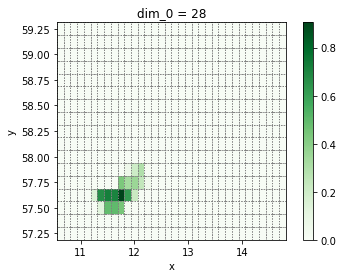

In [7]:
A = cutout.availabilitymatrix(this_kom, excluder)
i = vgr.index[vgr['kom_code'] == selected_kom_code][0]

fig, ax = plt.subplots()
A.sel(dim_0=i).plot(cmap="Greens")
this_kom.plot(ax=ax, edgecolor="k", color="None")
cutout.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")

print("Next step: Compine this cutout data with the different types, like wind power?")
should be eligability * the data?